<b>imports

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

<b>Set path label for file reading

In [8]:
path_label = "20230531_CVD_3158"

<b>file reading - Bruker

<b>File reading - Bruker data with added background

In [9]:
source = "Bruker-with-bg"

input_file = open("./" + path_label + "_map/" + path_label + "_60s_10x10pts_roi_net_sum.txt", "r")

sample_name = "CVD" + path_label[-4:]

#dat_xx_dx are 10x10 arrays
dat_si_d1 = np.zeros((10, 10))
dat_ga_d1 = np.zeros((10, 10))

dat_si_d2 = np.zeros((10, 10))
dat_ga_d2 = np.zeros((10, 10))

#how this works: readline returns a single empty string ONLY IF the EOF is reached
s = input_file.readline().split(" ") 
while s != [""]:

    if s[0][0] == "2": #check if it's a line containing data - 
                       #the line starts with the filename, which starts with the
                       #year, which starts with a 2
                       #this will break if you are using the script in the 31st
                       #century

        for i in range(len(s)-1, -1, -1):
            #run through list and delete empty strings
            #must run through backwards because if you go forwards, the length
            #will shrink over the course of the loop and it will go out of
            #range

            #empty strings could be avoided with split() with no delimiter, but
            #then the script wouldn't be able to distinguish between "\n" and ""
            #because split() has the same return value for both of those
            if s[i] == "":
                del s[i]
                
        x = int(s[0][-3]) #x is the slower changing index
        y = int(s[0][-1]) #y is the most rapidly changing index
        si_counts = float(s[1])
        ga_counts = float(s[6])
        if s[0][-5] == "1": #separate into detector 1 and detector 2
            dat_si_d1[x][y] = si_counts
            dat_ga_d1[x][y] = ga_counts
            
        elif s[0][-5] == "2":
            dat_si_d2[x][y] = si_counts
            dat_ga_d2[x][y] = ga_counts
               
    s = input_file.readline().split(" ")
        
input_file.close()

input_file_bg = open("./" + path_label + "_map/" + path_label + "_60s_10x10pts_roi_bg_sum.txt", "r")
s = input_file_bg.readline().split(" ")

while s != [""]:

    if s[0][0] == "2": #check if it's a line containing data - 
                       #the line starts with the filename, which starts with the
                       #year, which starts with a 2
                       #this will break if you are using the script in the 31st
                       #century

        for i in range(len(s)-1, -1, -1):
            #run through list and delete empty strings
            #must run through backwards because if you go forwards, the length
            #will shrink over the course of the loop and it will go out of
            #range

            #empty strings could be avoided with split() with no delimiter, but
            #then the script wouldn't be able to distinguish between "\n" and ""
            #because split() has the same return value for both of those
            if s[i] == "":
                del s[i]
                
        x = int(s[0][-3]) #x is the slower changing index
        y = int(s[0][-1]) #y is the most rapidly changing index
        si_counts = float(s[1])
        ga_counts = float(s[6])
        if s[0][-5] == "1": #separate into detector 1 and detector 2
            dat_si_d1[x][y] -= si_counts #subtraction because the counts in the background file are negative
            dat_ga_d1[x][y] -= ga_counts
        elif s[0][-5] == "2":
            dat_si_d2[x][y] -= si_counts
            dat_ga_d2[x][y] -= ga_counts
               
    s = input_file_bg.readline().split(" ")
        
input_file_bg.close()

#vec_xx_dx are vectors containing the data in no particular order
vec_si_d1 = dat_si_d1.reshape(100)
vec_si_d2 = dat_si_d2.reshape(100)
vec_ga_d1 = dat_ga_d1.reshape(100)
vec_ga_d2 = dat_ga_d2.reshape(100)

<b>file reading - PyMca

<b>statistical processing

In [10]:
trim_threshold = 2

def getStats(ar, thr):
    """calculate and return statistical properties of ar

    ar will be trimmed to remove data with |z| > thr

    ar must be a 1d array
    """
    av = np.average(ar)
    std = np.sqrt(np.sum((ar-av)**2)/ar.size)

    z = np.abs((ar - av) / std) # z-score of each element of ar
    mask = np.invert(np.array(z//thr, dtype=bool)) #mask[i] is true only if z[i] >= thr
    trim = ar[mask] #trim includes only elements ar[i] such that z[i] >= thr

    av_trim = np.average(trim)
    std_trim = np.sqrt(np.sum((trim-av_trim)**2)/trim.size)

    return av, std, av_trim, std_trim

avg_si_d1, std_si_d1, t_avg_si_d1, t_std_si_d1 = getStats(vec_si_d1, trim_threshold)
avg_si_d2, std_si_d2, t_avg_si_d2, t_std_si_d2 = getStats(vec_si_d2, trim_threshold)

avg_ga_d1, std_ga_d1, t_avg_ga_d1, t_std_ga_d1 = getStats(vec_ga_d1, trim_threshold)
avg_ga_d2, std_ga_d2, t_avg_ga_d2, t_std_ga_d2 = getStats(vec_ga_d2, trim_threshold)

print(sample_name + " Statistics, " + source)
print("Trim threshold: z >= " + str(trim_threshold))
print("\t\t\t\ttrimmed\ttrimmed")
print("Signal\tDet.\tAvg\tSTD\tavg\tstd")
print("Si\td1\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}".format(avg_si_d1, std_si_d1, t_avg_si_d1, t_std_si_d1))
print("Si\td2\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}".format(avg_si_d2, std_si_d2, t_avg_si_d2, t_std_si_d2))
print("Ga\td1\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}".format(avg_ga_d1, std_ga_d1, t_avg_ga_d1, t_std_ga_d1))
print("Ga\td2\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}".format(avg_ga_d2, std_ga_d2, t_avg_ga_d2, t_std_ga_d2))

stats_out_file = open("./" + path_label + "_map/results_out/" + path_label + "_stats_" + source + ".txt", "w")

stats_out_file.write(sample_name + " Statistics, " + source + "\n")
stats_out_file.write("Trim threshold: z >= " + str(trim_threshold) + "\n")
stats_out_file.write("\t\t\t\ttrimmed\ttrimmed\n")
stats_out_file.write("Signal\tDet.\tAvg\tSTD\tavg\tstd\n")
stats_out_file.write("Si\td1\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}\n".format(avg_si_d1, std_si_d1, t_avg_si_d1, t_std_si_d1))
stats_out_file.write("Si\td2\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}\n".format(avg_si_d2, std_si_d2, t_avg_si_d2, t_std_si_d2))
stats_out_file.write("Ga\td1\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}\n".format(avg_ga_d1, std_ga_d1, t_avg_ga_d1, t_std_ga_d1))
stats_out_file.write("Ga\td2\t{0:.0f}\t{1:.0f}\t{2:.0f}\t{3:.0f}\n".format(avg_ga_d2, std_ga_d2, t_avg_ga_d2, t_std_ga_d2))

stats_out_file.close()

CVD3158 Statistics, Bruker-with-bg
Trim threshold: z >= 2
				trimmed	trimmed
Signal	Det.	Avg	STD	avg	std
Si	d1	340220	1161	340359	896
Si	d2	354362	1349	354596	1001
Ga	d1	15116	119	15115	106
Ga	d2	15549	132	15553	116


<b>Generate probability plots

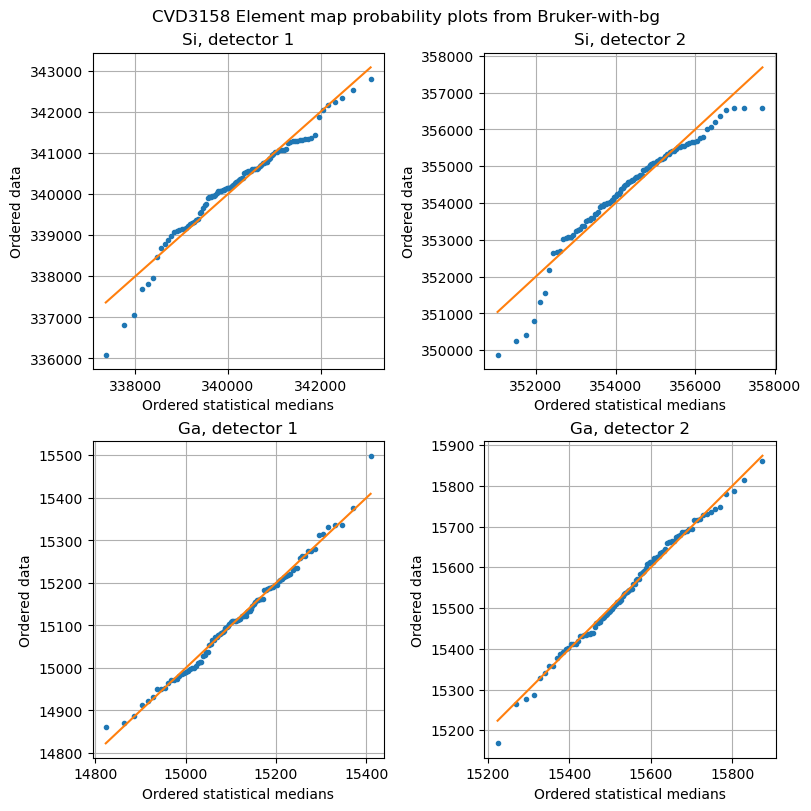

In [11]:
def probPlot(ax, dat, avg, std, title):
    osm, osr = stats.probplot(dat, (avg, std), dist="norm", fit=False)
    ax.plot(osm, osr, ".") #plot data
    ax.plot(osm, osm, "-") #plot line y=x
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel("Ordered statistical medians")
    ax.set_ylabel("Ordered data")

f, ((ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=2, ncols = 2, figsize = (8, 8), layout="constrained")

probPlot(ax7, vec_si_d1, avg_si_d1, std_si_d1, "Si, detector 1")
probPlot(ax8, vec_si_d2, avg_si_d2, std_si_d2, "Si, detector 2")
probPlot(ax9, vec_ga_d1, avg_ga_d1, std_ga_d1, "Ga, detector 1")
probPlot(ax10, vec_ga_d2, avg_ga_d2, std_ga_d2, "Ga, detector 2")

f.suptitle(sample_name + " Element map probability plots from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_prob_plots_" + source + ".png",
            dpi="figure",
            format="png")

<b>plot heatmap results

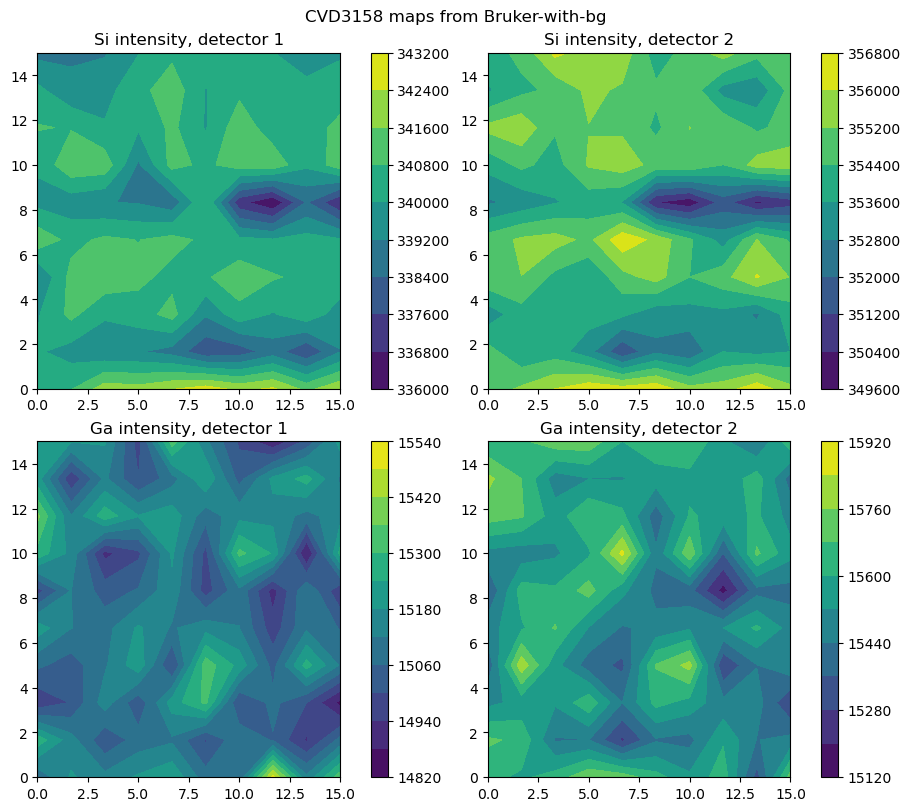

In [12]:
c="viridis"
fg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 8), layout="constrained")

def drawMap(a, dat, cm, title):
    """draw contour plot
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.contourf(dat, levels = 10, extent = [0, 15, 0, 15], cmap = cm)
    plt.colorbar(im_pointer, ax=a)
    a.set_title(title)

drawMap(ax1, dat_si_d1, c, "Si intensity, detector 1")
drawMap(ax2, dat_si_d2, c, "Si intensity, detector 2")

drawMap(ax3, dat_ga_d1, c, "Ga intensity, detector 1")
drawMap(ax4, dat_ga_d2, c, "Ga intensity, detector 2")

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right